In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() != None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
#     print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [6]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

In [8]:
dfhw=pd.read_csv("01_heights_weights_genders.csv")
print(dfhw.shape)
dfhw.head()

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [9]:
df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

260

In [10]:
df.shape[0]

500

In [11]:
itrain, itest = train_test_split(np.arange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True])

using mask


c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users

BEST {'C': 0.001} 0.95 {'mean_fit_time': array([0.04217553, 0.00099788, 0.00079761, 0.00126581, 0.00094094,
       0.        , 0.        , 0.        ]), 'std_fit_time': array([7.77555269e-02, 2.22533317e-05, 1.59521103e-03, 1.56599745e-03,
       1.66031176e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'mean_score_time': array([0.00020633, 0.00017767, 0.        , 0.        , 0.00041146,
       0.00313463, 0.00312443, 0.        ]), 'std_score_time': array([0.00041265, 0.00035534, 0.        , 0.        , 0.00050397,
       0.00626926, 0.00624886, 0.        ]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}, {'C': 10000}], 'split0_test_score': array([0.93442623, 0.93442623, 0.93442623, 0.93442623, 0.93442623,
       0.93442623, 0.934426

c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


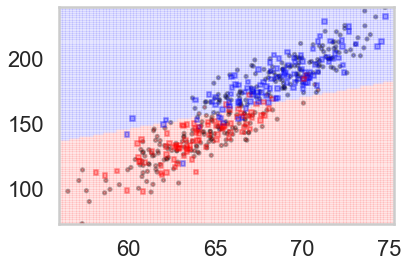

In [12]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [13]:
clflog.predict(Xtest)

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0])

In [14]:
clflog.predict_proba(Xtest)

array([[0.89103768, 0.10896232],
       [0.88942903, 0.11057097],
       [0.16875366, 0.83124634],
       [0.01828541, 0.98171459],
       [0.1459657 , 0.8540343 ],
       [0.15766702, 0.84233298],
       [0.58893026, 0.41106974],
       [0.2915198 , 0.7084802 ],
       [0.05222346, 0.94777654],
       [0.81395195, 0.18604805],
       [0.05084434, 0.94915566],
       [0.79633387, 0.20366613],
       [0.74034957, 0.25965043],
       [0.24579995, 0.75420005],
       [0.44628239, 0.55371761],
       [0.71027046, 0.28972954],
       [0.66779241, 0.33220759],
       [0.95868336, 0.04131664],
       [0.44957136, 0.55042864],
       [0.08222798, 0.91777202],
       [0.2371018 , 0.7628982 ],
       [0.1968231 , 0.8031769 ],
       [0.92020939, 0.07979061],
       [0.61761089, 0.38238911],
       [0.3269899 , 0.6730101 ],
       [0.37694752, 0.62305248],
       [0.80649991, 0.19350009],
       [0.05358279, 0.94641721],
       [0.67589424, 0.32410576],
       [0.97690136, 0.02309864],
       [0.

In [15]:
clflog.predict_proba(Xtest)[:,1]

array([0.10896232, 0.11057097, 0.83124634, 0.98171459, 0.8540343 ,
       0.84233298, 0.41106974, 0.7084802 , 0.94777654, 0.18604805,
       0.94915566, 0.20366613, 0.25965043, 0.75420005, 0.55371761,
       0.28972954, 0.33220759, 0.04131664, 0.55042864, 0.91777202,
       0.7628982 , 0.8031769 , 0.07979061, 0.38238911, 0.6730101 ,
       0.62305248, 0.19350009, 0.94641721, 0.32410576, 0.02309864,
       0.16523021, 0.81756014, 0.53540492, 0.5934709 , 0.3205745 ,
       0.50928232, 0.49865089, 0.13866635, 0.98704485, 0.91196653,
       0.92580064, 0.40503664, 0.63555873, 0.03264183, 0.73379384,
       0.05549893, 0.33386064, 0.17024611, 0.29951204, 0.9114883 ,
       0.53960649, 0.62031758, 0.32689123, 0.57638104, 0.12123977,
       0.76104619, 0.17099117, 0.85361103, 0.73670312, 0.7794384 ,
       0.67054564, 0.8972938 , 0.33141829, 0.83045195, 0.91060022,
       0.79069874, 0.38061123, 0.12172674, 0.79502586, 0.9241381 ,
       0.01220185, 0.68872502, 0.77080347, 0.41177619, 0.64859

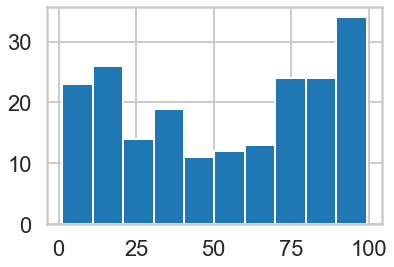

In [16]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


TypeError: clabel() got an unexpected keyword argument 'axes'

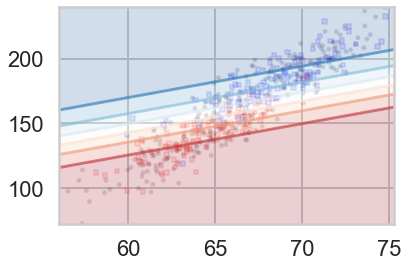

In [17]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [18]:
clflog.score(Xtest, ytest)

0.9

using mask
BEST {'C': 0.001} 0.9466666666666667 {'mean_fit_time': array([7.98463821e-04, 1.95455551e-04, 1.00722313e-03, 3.72366905e-03,
       2.44336128e-02, 8.23471069e-02, 2.16677761e-01]), 'std_fit_time': array([0.00039923, 0.00039091, 0.00155079, 0.0014433 , 0.02115917,
       0.04271681, 0.12015251]), 'mean_score_time': array([0.00025377, 0.0010251 , 0.00082655, 0.        , 0.0007997 ,
       0.00020723, 0.00223665]), 'std_score_time': array([0.00039401, 0.00158676, 0.0016531 , 0.        , 0.00159941,
       0.00041447, 0.00159458]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.95081967, 0.95081967, 0.93442623, 0.93442623, 0.93442623,
       0.93442623, 0.93442623]), 'split1_test_score': array([0.9       , 0.9      

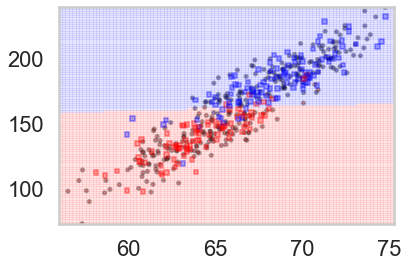

In [19]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [20]:
clfsvm.decision_function(Xtest)

array([-3.18097200e+00, -3.12832820e+00,  1.70623764e+00,  5.95114168e+00,
        1.95294840e+00,  2.49625192e+00, -1.19613219e+00,  1.24407873e+00,
        5.08665403e+00, -1.66678633e+00,  4.11997362e+00, -2.04593980e+00,
       -1.83569750e+00,  1.31447941e+00, -2.87227656e-02, -1.64536953e+00,
       -1.38994450e+00, -4.55277341e+00, -7.40499535e-01,  3.78109114e+00,
        1.98590999e+00,  2.42161862e+00, -4.10009237e+00, -9.34682645e-01,
        1.00022949e+00,  3.56456039e-01, -2.01290080e+00,  3.96823770e+00,
       -1.42335217e+00, -4.99609379e+00, -2.87491941e+00,  2.52067406e+00,
       -2.80540960e-02,  2.49092246e-01, -1.84721754e+00, -3.97401820e-02,
        4.14988059e-03, -2.85882231e+00,  6.36069909e+00,  3.13579654e+00,
        3.97816843e+00, -1.16876245e+00,  5.75900134e-01, -4.94075861e+00,
        1.93343172e+00, -5.05707395e+00, -1.11687551e+00, -1.88623297e+00,
       -1.16696472e+00,  2.56552222e+00,  3.28276608e-01,  4.92332768e-01,
       -1.46571220e+00,  

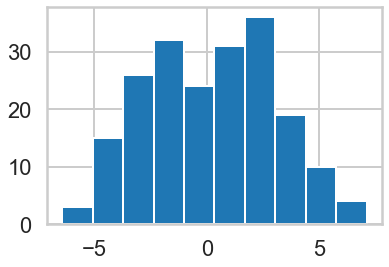

In [21]:
plt.hist(clfsvm.decision_function(Xtest));

c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


TypeError: clabel() got an unexpected keyword argument 'axes'

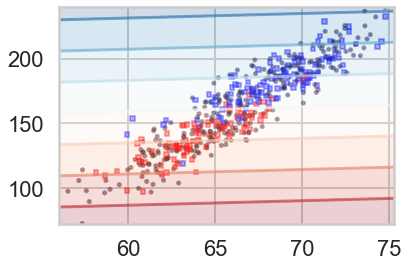

In [22]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

In [23]:
def plot_svc_decision_function(clf, ax=None):
    
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

ValueError: Expected 2D array, got 1D array instead:
array=[56.03416581 72.25014469].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

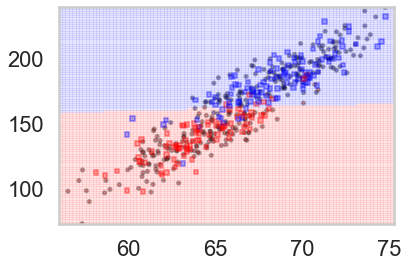

In [24]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

In [25]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[82,  9],
       [11, 98]], dtype=int64)

In [26]:
from sklearn.metrics import classification_report
print (classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        91
           1       0.92      0.90      0.91       109

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [27]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [28]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[ 19,  72],
       [  1, 108]], dtype=int64)

In [29]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

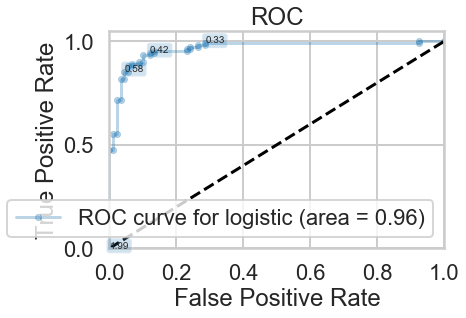

In [30]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

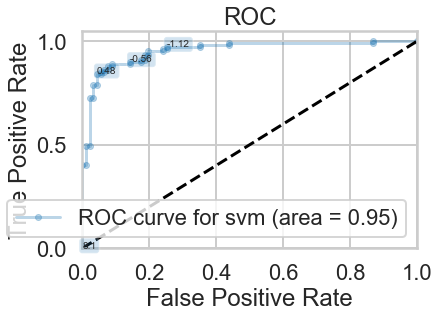

In [31]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)